Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [26]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [27]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [28]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [29]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

# data holds the dictionary index of each word in dataset
# count holds the list of 50000 most common words in dataset, with the number of times each appears
# dictionary holds a list of 50000 most common words, with their index within the dictionary
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Sample data', data[:10])
print('Most common words (+UNK)', count[:5])
for (n, d) in enumerate(dictionary):
    print('Dictionary entry {}'.format(d))
    if n >= 10:
        break
del words  # Hint to reduce memory.

Sample data [5244, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]
Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Dictionary entry anatomy
Dictionary entry felling
Dictionary entry courant
Dictionary entry agent
Dictionary entry threefold
Dictionary entry becquerel
Dictionary entry municipal
Dictionary entry rack
Dictionary entry uae
Dictionary entry gao
Dictionary entry auditors


Function to generate a training batch for the skip-gram model.

In [30]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [31]:
print('data:', [reverse_dictionary[di] for di in data[:8]])

# skip_window = How many words to consider left and right.
# num_skips = How many times to reuse an input to generate a label.

for num_skips, skip_window in [(2, 1), (4, 2), (8, 4), (2, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'originated', 'a', 'term', 'of', 'originated', 'as']

with num_skips = 8 and skip_window = 4:
    batch: ['term', 'term', 'term', 'term', 'term', 'term', 'term', 'term']
    labels: ['anarchism', 'a', 'originated', 'of', 'first', 'abuse', 'used', 'as']

with num_skips = 2 and skip_window = 2:
    batch: ['as', 'as', 'a', 'a', 'term', 'term', 'of', 'of']
    labels: ['a', 'term', 'term', 'as', 'of', 'as', 'first', 'term']


Train a skip-gram model.

In [32]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [33]:
num_steps = 100001

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(graph=graph, config=config) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.301340
Nearest to be: grabbing, dura, jurisdictions, factoring, sapphire, theorems, jaya, lleida,
Nearest to there: ministerial, processor, workmen, ferries, ferrari, interferometry, rake, funneled,
Nearest to was: warranted, despite, homonyms, renunciation, year, cg, humans, busiest,
Nearest to from: deep, adaptation, gylfaginning, logician, recur, thereby, concentrates, bootlegs,
Nearest to one: shelf, cum, creationist, cal, antenna, memorabilia, threaded, coriander,
Nearest to more: beefheart, wissowa, germanicus, coconut, esperantists, ccds, hydroxyl, sahib,
Nearest to during: parlement, quincey, preaching, airbase, sorry, guillaume, apollo, syringe,
Nearest to people: hooking, mit, corsican, voucher, compuserve, summed, comeback, tap,
Nearest to six: saxophones, slaves, cavendish, jubilees, disestablishment, fungus, arranged, nanosystems,
Nearest to state: mil, rights, monads, allusion, academically, flights, monarchies, spaniel,
Nearest to of

Average loss at step 52000: 3.434696
Average loss at step 54000: 3.423750
Average loss at step 56000: 3.439331
Average loss at step 58000: 3.400665
Average loss at step 60000: 3.390097
Nearest to be: been, is, was, become, are, dwelling, have, were,
Nearest to there: they, it, often, now, he, this, still, she,
Nearest to was: is, became, had, were, has, been, be, when,
Nearest to from: through, under, into, concentrates, in, during, gylfaginning, hif,
Nearest to one: two, six, four, seven, eight, five, three, nine,
Nearest to more: less, most, rather, very, greater, extremely, revealing, larger,
Nearest to during: after, before, following, in, under, although, within, at,
Nearest to people: men, individuals, bysshe, those, others, subjects, yankovic, jews,
Nearest to six: eight, four, five, nine, seven, three, zero, two,
Nearest to state: government, city, rights, attitudes, result, istria, establishment, examinations,
Nearest to of: for, in, terracotta, same, like, fraudulent, surrend

In [34]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

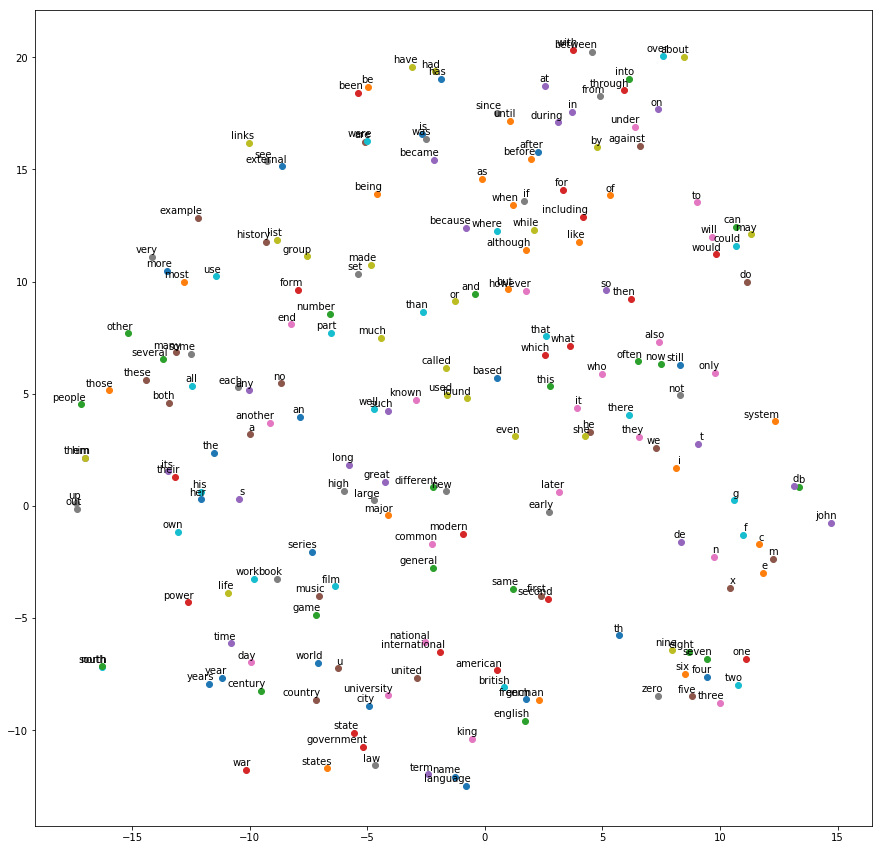

In [35]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [36]:
data_index = 0

def generate_cbow_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i , j] = buffer[target]
      labels[i , 0] = buffer[skip_window]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

In [37]:
print('data:', [reverse_dictionary[di] for di in data[:16]])

# skip_window = How many words to consider left and right.
# num_skips = How many times to reuse an input to generate a label.

for num_skips, skip_window in [(2, 1), (4, 2), (8, 4), (2, 2)]:
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    for k in range(0, batch.shape[1]):
        print('     batch({}/{}): {}'.format(k, batch.shape[1], [reverse_dictionary[bi] for bi in batch[:,k].reshape(8)]))
    print('         labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with num_skips = 2 and skip_window = 1:
     batch(0/2): ['as', 'originated', 'term', 'a', 'term', 'first', 'abuse', 'first']
     batch(1/2): ['anarchism', 'a', 'as', 'of', 'abuse', 'of', 'used', 'against']
         labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
     batch(0/4): ['anarchism', 'term', 'as', 'abuse', 'used', 'against', 'first', 'working']
     batch(1/4): ['a', 'originated', 'abuse', 'a', 'term', 'abuse', 'abuse', 'used']
     batch(2/4): ['originated', 'as', 'of', 'first', 'first', 'of', 'against', 'first']
     batch(3/4): ['term', 'of', 'a', 'term', 'of', 'used', 'early', 'early']
         labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 8 and skip_window = 4:
     batch(0/8): ['abuse', 'as', 'against', 'o

Train cbow model

In [38]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed_prev = tf.nn.embedding_lookup(embeddings, train_dataset) # batch_size x num_skips x embedding_size
  embed = tf.reduce_mean(embed_prev, 1) # average embed prev over 1st dimension in order to get batch_size x embedding_size
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [39]:
num_steps = 100001

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(graph=graph, config=config) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.335356
Nearest to one: mta, applauded, thirteen, classify, rtf, miletus, unaids, vita,
Nearest to or: ladies, honeydew, cuff, kashmir, gogo, rad, tyranny, cybernetic,
Nearest to when: potatoes, emanation, bun, mantle, bara, ford, inaugurated, tongues,
Nearest to is: elliot, mummified, paranoia, ust, compensation, pretender, exhibit, sensing,
Nearest to it: prakrit, helium, mckean, dues, deficit, dembski, recommendations, unknowns,
Nearest to of: narrowest, devising, flick, detriment, beech, nationalized, caught, postman,
Nearest to their: jn, captives, planting, benthic, christiansen, expressiveness, marle, activated,
Nearest to most: modulator, ebenezer, pieced, openings, character, dona, cog, dflp,
Nearest to such: lothian, barnard, normandy, horowitz, indentation, needle, nibble, mariah,
Nearest to i: homebrew, weinstein, elihu, asking, perpetual, crossbow, hobart, anhalt,
Nearest to into: topologically, tikal, waldeck, derby, honda, golfer, wie

Average loss at step 52000: 2.887770
Average loss at step 54000: 2.865774
Average loss at step 56000: 2.861037
Average loss at step 58000: 2.764180
Average loss at step 60000: 2.828909
Nearest to one: two, four, six, seven, five, eight, three, nine,
Nearest to or: and, than, accidently, kabila, foobar, embarked, stv, overt,
Nearest to when: if, where, before, until, after, while, during, then,
Nearest to is: was, has, requires, are, seems, makes, be, becomes,
Nearest to it: he, she, there, this, they, which, we, today,
Nearest to of: maximal, ama, theologiae, staffing, phonation, magnetron, naguib, brno,
Nearest to their: its, his, her, your, our, my, the, whose,
Nearest to most: more, many, some, less, particularly, redrawn, associations, dflp,
Nearest to such: these, including, many, known, opposed, stumbling, act, certain,
Nearest to i: you, ii, we, typed, g, watts, galen, int,
Nearest to into: through, from, back, within, takashi, macao, eiffel, during,
Nearest to seven: five, eigh

In [40]:
num_points = 200

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

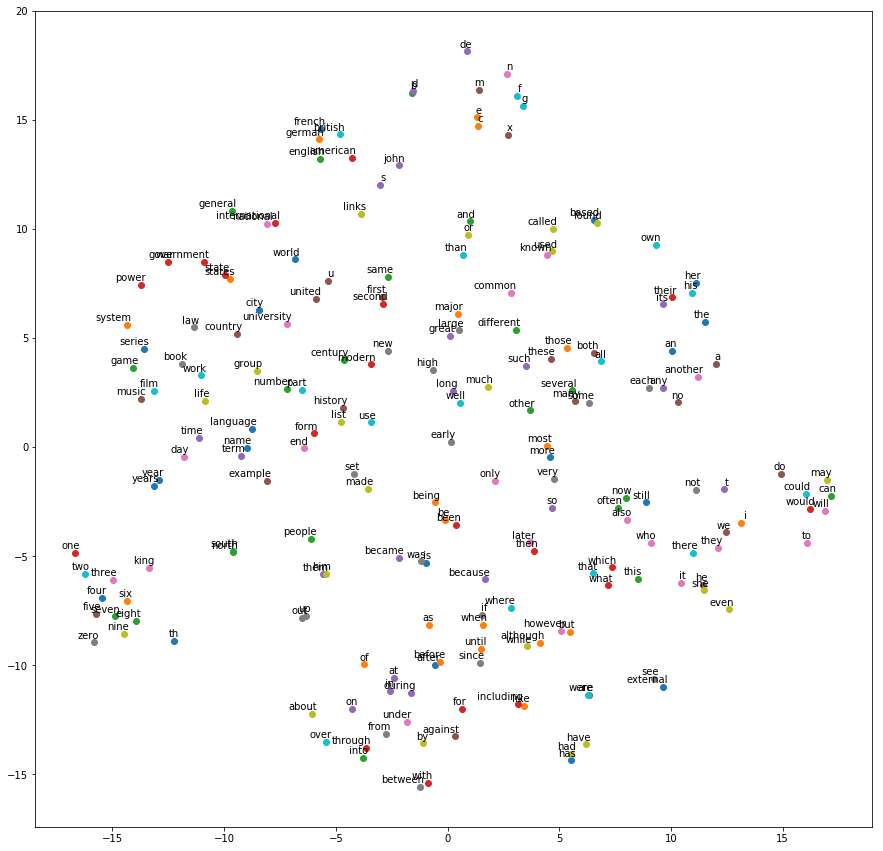

In [41]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

architecture: skip-gram (slower, better for infrequent words) vs CBOW (fast)

An answer from a forum (https://stats.stackexchange.com/questions/180548/why-is-skip-gram-better-for-infrequent-words-than-cbow):

In CBOW the vectors from the context words are averaged before predicting the center word. In skip-gram there is no averaging of embedding vectors. It seems like the model can learn better representations for the rare words when their vectors are not averaged with the other context words in the process of making the predictions.